# Edibility of Mushrooms
## Introduction:
Mushrooms can be made for delicious dishes, but some of them are poisonous! Predicting the edibility from its appearance would be essential when we encounter a an unknown mushroom.

- In our project, we aim to train a model which uses classification method to predict whether an unknown mushroom is edible or poisonous given various dimensions in its appearance.

#### The Dataset:
- "Secondary mushroom data" from UCI Machine Learning Repository (https://mushroom.mathematik.uni-marburg.de/files/) 
- Includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species)
- Each mushroom is identified as edible, poisonous, or of unknown edibility
- Of the 20 variables, 3 are continuous, and 17 are nominal (3 are binary, and 14 are categorical)

## Preliminary exploratory data analysis:
#### - Read, clean and wrangle data into a tidy format

In [24]:
library(tidyverse)
library(tidymodels)
library(cowplot)
set.seed(777)
link <- "https://mushroom.mathematik.uni-marburg.de/files/SecondaryData/secondary_data_shuffled.csv"
mushrooms <- read_delim(link, delim=";") # download our dataset
head(mushrooms) # show the first 6 examples

Rows: 61069 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (16): class, cap-shape, cap-surface, cap-color, gill-attachment, gill-sp...
dbl  (3): cap-diameter, stem-height, stem-width
lgl  (2): does-bruise-or-bleed, has-ring

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed
1 e     1.72         x         s           y         FALSE               
2 e     9.59         f         e           b         FALSE               
3 p     0.86         x         g           p         FALSE               
4 p     4.32         x         NA          e         FALSE               
5 e     2.80         x         s           w         FALSE               
6 p     1.18         s         s           y         FALSE               
  gill-attachment gill-spacing gill-color stem-height ⋯ stem-root stem-surface
1 d               NA           w          7.01        ⋯ NA        t           
2 NA              c            b          4.73        ⋯ NA        NA          
3 a               NA           p          4.25        ⋯ NA        s           
4 x               NA           w          4.91        ⋯ NA        NA          
5 d               d            w          3.13        ⋯ NA        NA          
6 f               f            f          3.39        ⋯ NA        NA          
  stem-color veil-type veil-color has-ring ring-type spore-print-color habitat
1 y          NA        NA         FALSE    f         NA                h      
2 w          NA        NA          TRUE    f         NA                d      
3 k          NA        NA         FALSE    f         NA                d      
4 w          NA        NA         FALSE    f         NA                d      
5 w          NA        NA         FALSE    f         NA                m      
6 y          NA        NA         FALSE    f         NA                d      
  season
1 u     
2 a     
3 s     
4 u     
5 a     
6 u

#### - Add column names and split data into training and testing sets

In [26]:
new_colnames <- map(colnames(mushrooms), function (col_name) gsub("-", "_", col_name)) # replace '-' with '_'
new_colnames[2] <- 'diameter' # compact the names of diameter, height, and width
new_colnames[10] <- 'height'
new_colnames[11] <- 'width'
colnames(mushrooms) <- new_colnames
mushroom_split <- mushrooms |>
    mutate(across(-c(diameter, height, width), factor)) |>
    initial_split(prop=0.75, strata=class)
mushroom_training_raw <- training(mushroom_split)
mushroom_training <- mushroom_training_raw |>
    select(class, diameter, height, width)
head(mushroom_training)

class diameter height width
1 e      1.72     7.01   2.36
2 e      9.59     4.73  20.49
3 e      2.80     3.13   5.69
4 e     15.55    12.36  19.06
5 e      5.76     8.11  17.69
6 e     11.53     8.99  18.61

#### - Summarize the data (Number of observations, means, and amount of missing data)

In [11]:
#This table reports the number of observations in each class
summarize_mushroom <- mushroom_training |>
    group_by(class) |>
    summarize(n = n())
summarize_mushroom

#This table gives the means of the predictor variables in our analysis
means_mushroom <- mushroom_training |>
    select(-class) |>
    map_df(mean)
    means_mushroom

#This calculates the number of rows that have missing data
missing_data <- mushroom_training |>
    filter(is.na(class) || is.na(diameter) || is.na(height) || is.na(width)) |>
    nrow()
missing_data

# sum(apply(mushroom_training, 1, function(x) any(is.na(x))) == TRUE) # count rows with na, same as above

class n    
1 e     20385
2 p     25416

diameter height   width   
1 6.729185 6.574405 12.11532

[1] 0

#### - Visualization of continuous variables 

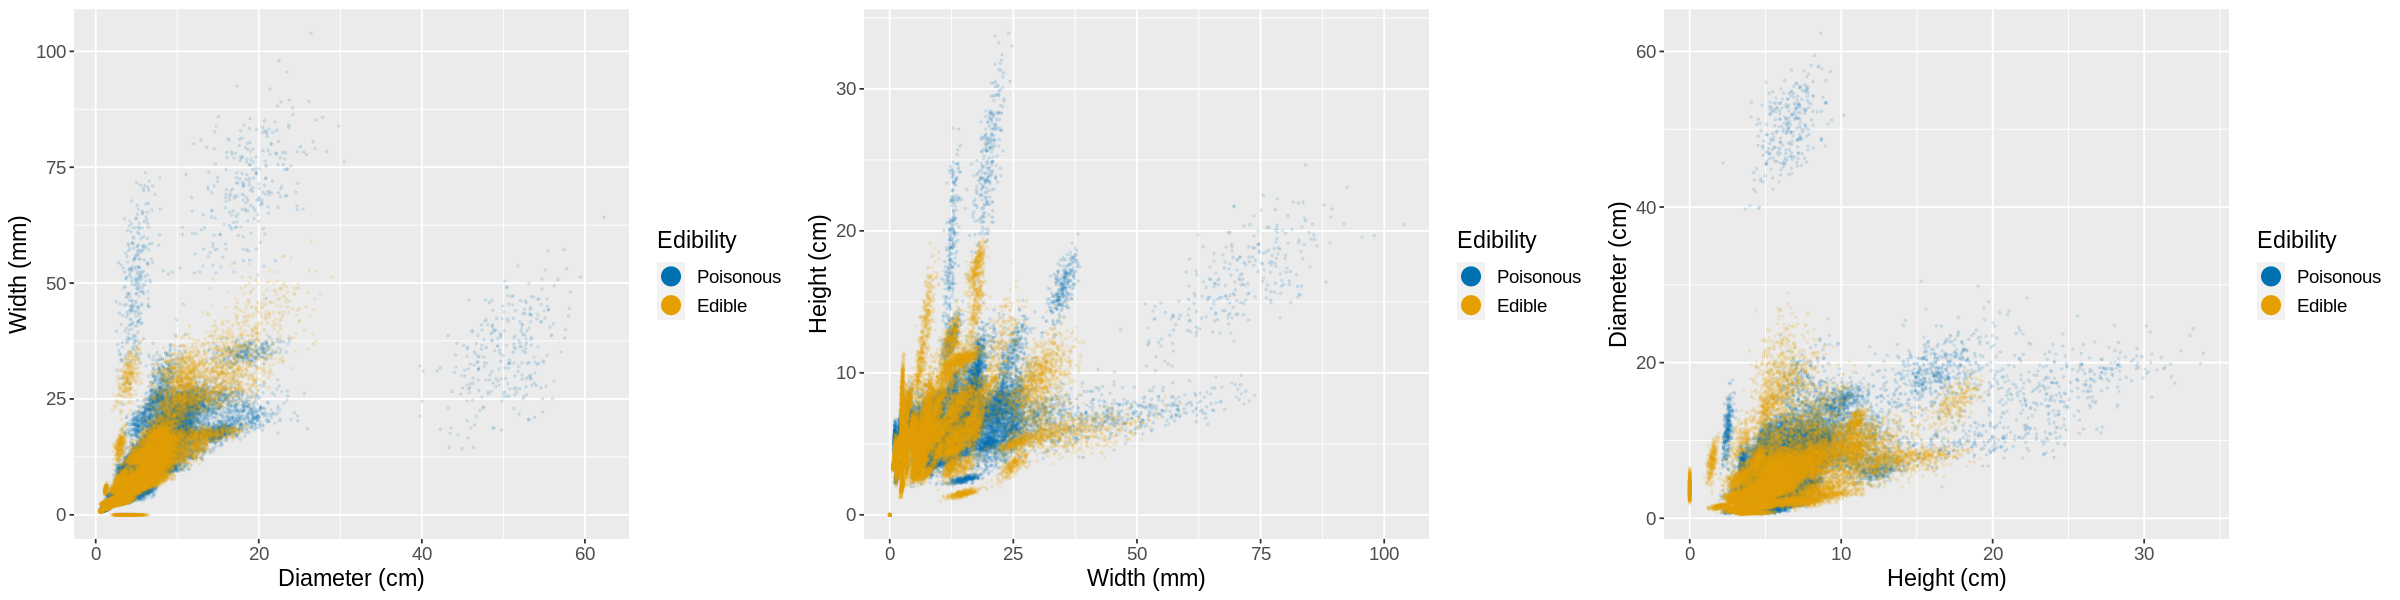

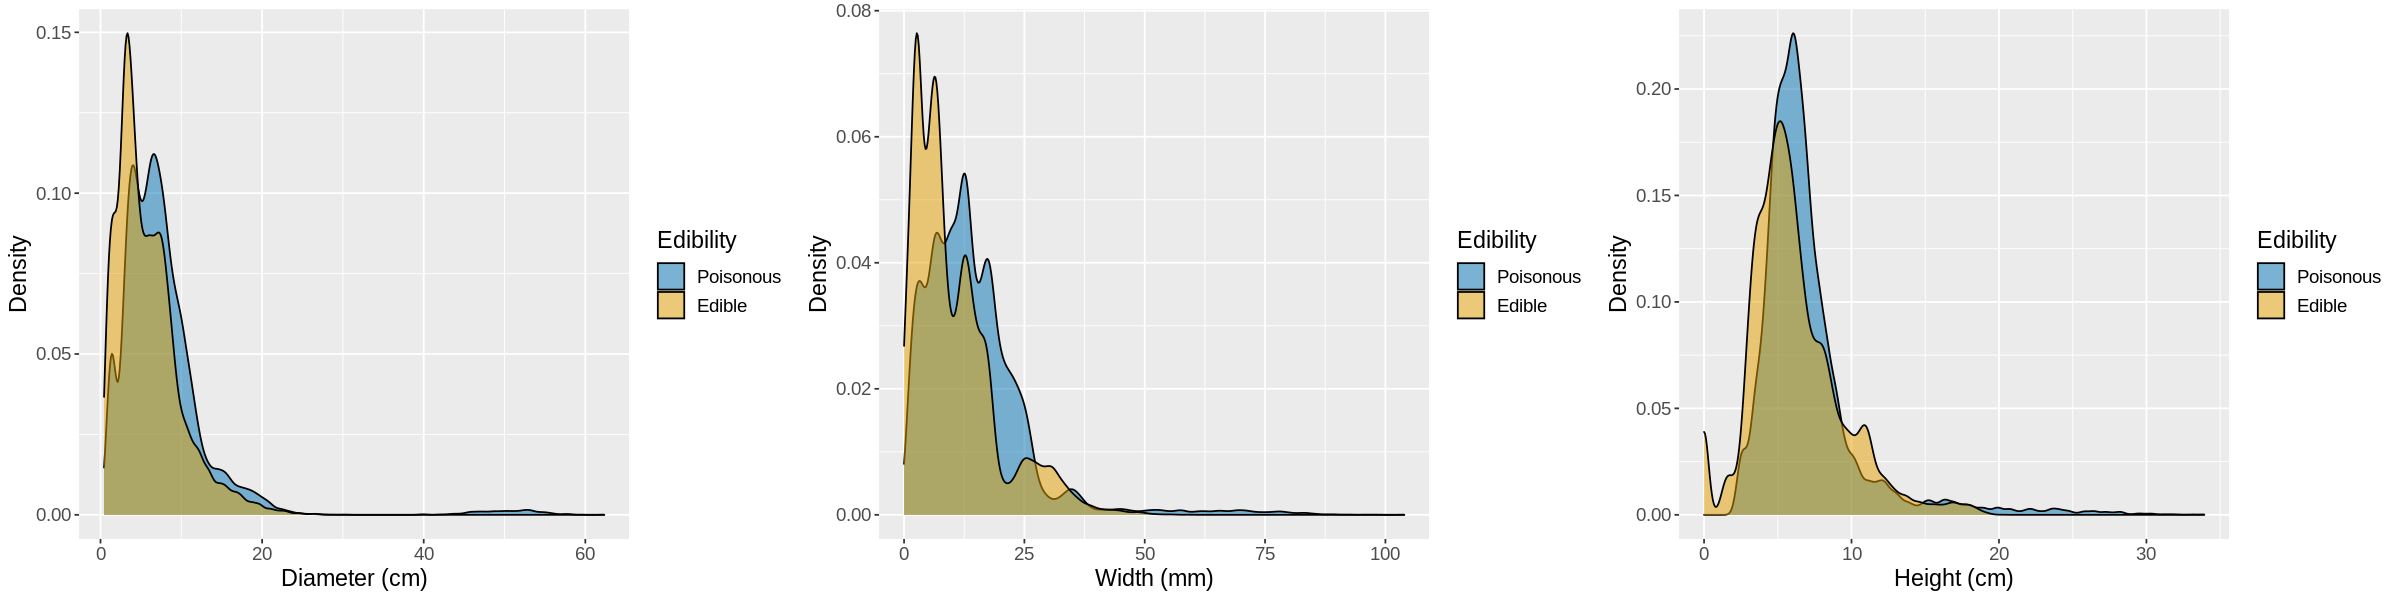

In [34]:
#library(rcartocolor)

mushroom_plot1 <- mushroom_training |>
    ggplot(aes(x=diameter, y=width, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Diameter (cm)", y="Width (mm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))
mushroom_plot2 <- mushroom_training |>
    ggplot(aes(x=width, y=height, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Width (mm)", y="Height (cm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))
mushroom_plot3 <- mushroom_training |>
    ggplot(aes(x=height, y=diameter, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Height (cm)", y="Diameter (cm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

#mushroom_plot1
#mushroom_plot2
#mushroom_plot3


# Marginal density plot of diamter (top panel)
diameterDensity <- ggplot(mushroom_training, aes(diameter, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Diameter (cm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#diameterDensity

# Marginal density plot of width (right panel)
widthDensity <- ggplot(mushroom_training, aes(width, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Width (mm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#widthDensity

# Marginal density plot of height
heightDensity <- ggplot(mushroom_training, aes(height, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Height (cm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#heightDensity

options(repr.plot.width = 20, repr.plot.height = 5)
plot_grid(mushroom_plot1, mushroom_plot2, mushroom_plot3, ncol = 3)
plot_grid(diameterDensity, widthDensity, heightDensity, ncol = 3)
# consider side-by-side instead of overlap

We can see that the dimensions of poison and edible mushrooms follow simlar trends, however, there are also many large outlier clusters that entirely consist of one class.

#### - Visualization of categorical variables 

In [15]:

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Can edit these to configure charts below                                        #
#                                                                                 #
selectedCols <- mushroom_training_raw |>                                          #
    # select(does_bruise_or_bleed, veil_type, has_ring, cap_shape, cap_color)     #
    select(-c(class, diameter, width, height))                                    #
x_var <- "Height"                                                                 #
y_var <- "Diameter"                                                               #
x_lim <- c(0, 15) # c(0,35)                                                       #
y_lim <- c(0, 25) # c(0,65)                                                       #
sampleRate <- .3 # useless                                                      # #
#                                                                             # # #
#                                                                           # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

set.seed(777)
cat_vars <- selectedCols |> 
    # sample_n(nrow(mushroom_training_raw) * sampleRate) |>
    map_df(~ tibble(x=.x), .id="dist") |>
    mutate(dist=as_factor(dist))
cat_vars_full <- selectedCols |> 
    map_df(~ tibble(x=.x), .id="dist") |>
    mutate(dist=as_factor(dist))
# cat_vars |>
# group_by(dist) |>
# summarize(n=n())

set.seed(777)
poisonPlots <- map(colnames(selectedCols), function(col_name)
    plot_grid(
        cat_vars |>
        filter(dist == col_name) |>
        cbind(mushroom_training
              # |> sample_n(nrow(mushroom_training_raw) * sampleRate)
        ) |>
        filter(class == "p") |>
        ggplot(aes_string(x=tolower(x_var), y=tolower(y_var), color="x")) +
        geom_point(size=0.3, na.rm = TRUE) +
        labs(x=x_var, y=y_var, color="") +
        lims(x = x_lim, y = y_lim) +
        theme(
            panel.background = element_rect(fill = alpha('blue', 0.05), colour = 'black'), 
            # legend.position="none", # "top", 
            aspect.ratio=1, 
            plot.margin = unit(c(2, 0, 0, 2), "cm"), # c(t, r, b, l)
            plot.title = element_text(hjust = 0.5)
        ) + 
        theme(
            legend.position = c(.05, 1),
            legend.justification = c("left", "top"),
            legend.box.just = "left",
            legend.margin = margin(0, 0, 0, 0),
            legend.key.size = unit(.5, 'cm'), #change legend key size
            legend.key.height = unit(.5, 'cm'), #change legend key height
            legend.key.width = unit(.5, 'cm'), #change legend key width
            legend.background = element_rect(fill = alpha('yellow', 0)),
            legend.key = element_rect(fill = alpha('yellow', 0)),
        ) + 
        guides(color = guide_legend(override.aes = list(size = 5))) +
        ggtitle(paste(col_name, "Poisonous", sep=" | ")),
        cat_vars_full |>
            filter(dist == col_name) |>
            cbind(mushroom_training) |>
            filter(class == "p") |>
            group_by(x) |>
            summarize(n=n()) |>
            ggplot(aes(fill=x,y=n,x='')) + 
                geom_bar(position="fill", stat="identity") +
                theme_bw() +
                theme(axis.title.x=element_blank(),
                    axis.text.x=element_blank(),
                    axis.ticks.x=element_blank(),
                    axis.title.y=element_blank(),
                    axis.text.y=element_blank(),
                    axis.ticks.y=element_blank(),
                    legend.position="none") + 
                theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                theme(panel.border = element_blank()) +
                theme(aspect.ratio=20, plot.margin=unit(c(2,0,0,0), "cm")),
        ncol=2,
        rel_widths=c(1,.1)
    )
)
set.seed(777)
ediblePlots <- map(colnames(selectedCols), function(col_name)
    plot_grid(
        cat_vars_full |>
            filter(dist == col_name) |>
            cbind(mushroom_training) |>
            filter(class == "e") |>
            group_by(x) |>
            summarize(n=n()) |>
            ggplot(aes(fill=x,y=n,x='')) + 
                geom_bar(position="fill", stat="identity") +
                theme_bw() +
                theme(axis.title.x=element_blank(),
                    axis.text.x=element_blank(),
                    axis.ticks.x=element_blank(),
                    axis.title.y=element_blank(),
                    axis.text.y=element_blank(),
                    axis.ticks.y=element_blank(),
                    legend.position="none") + 
                theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                theme(panel.border = element_blank()) +
                theme(aspect.ratio=20, plot.margin=unit(c(2,0,0,0), "cm")),
        cat_vars |>
            filter(dist == col_name) |>
            cbind(mushroom_training
                  # |> sample_n(nrow(mushroom_training_raw) * sampleRate)
            ) |>
            filter(class == "e") |>
            ggplot(aes_string(x=tolower(x_var), y=tolower(y_var), color="x")) +
            geom_point(size=0.3, na.rm = TRUE) +
            labs(x=x_var, y=y_var, color="") +
            lims(x = x_lim, y = y_lim) +
            theme(
                axis.title.y=element_blank(),
                panel.background = element_rect(fill = alpha('yellow', 0.05), colour = 'black'), 
                aspect.ratio=1,
                plot.margin = unit(c(2, 2, 0, 0), "cm"), # c(t, r, b, l)
                plot.title = element_text(hjust = 0.5),
                legend.position = "none"
            ) +
            ggtitle(paste(col_name, "Edible", sep=" | ")),
        ncol=2,
        rel_widths=c(.1,1)
    )
)

# options(repr.plot.width = 4, repr.plot.height = 4)
plots <- c(rbind(poisonPlots,ediblePlots))

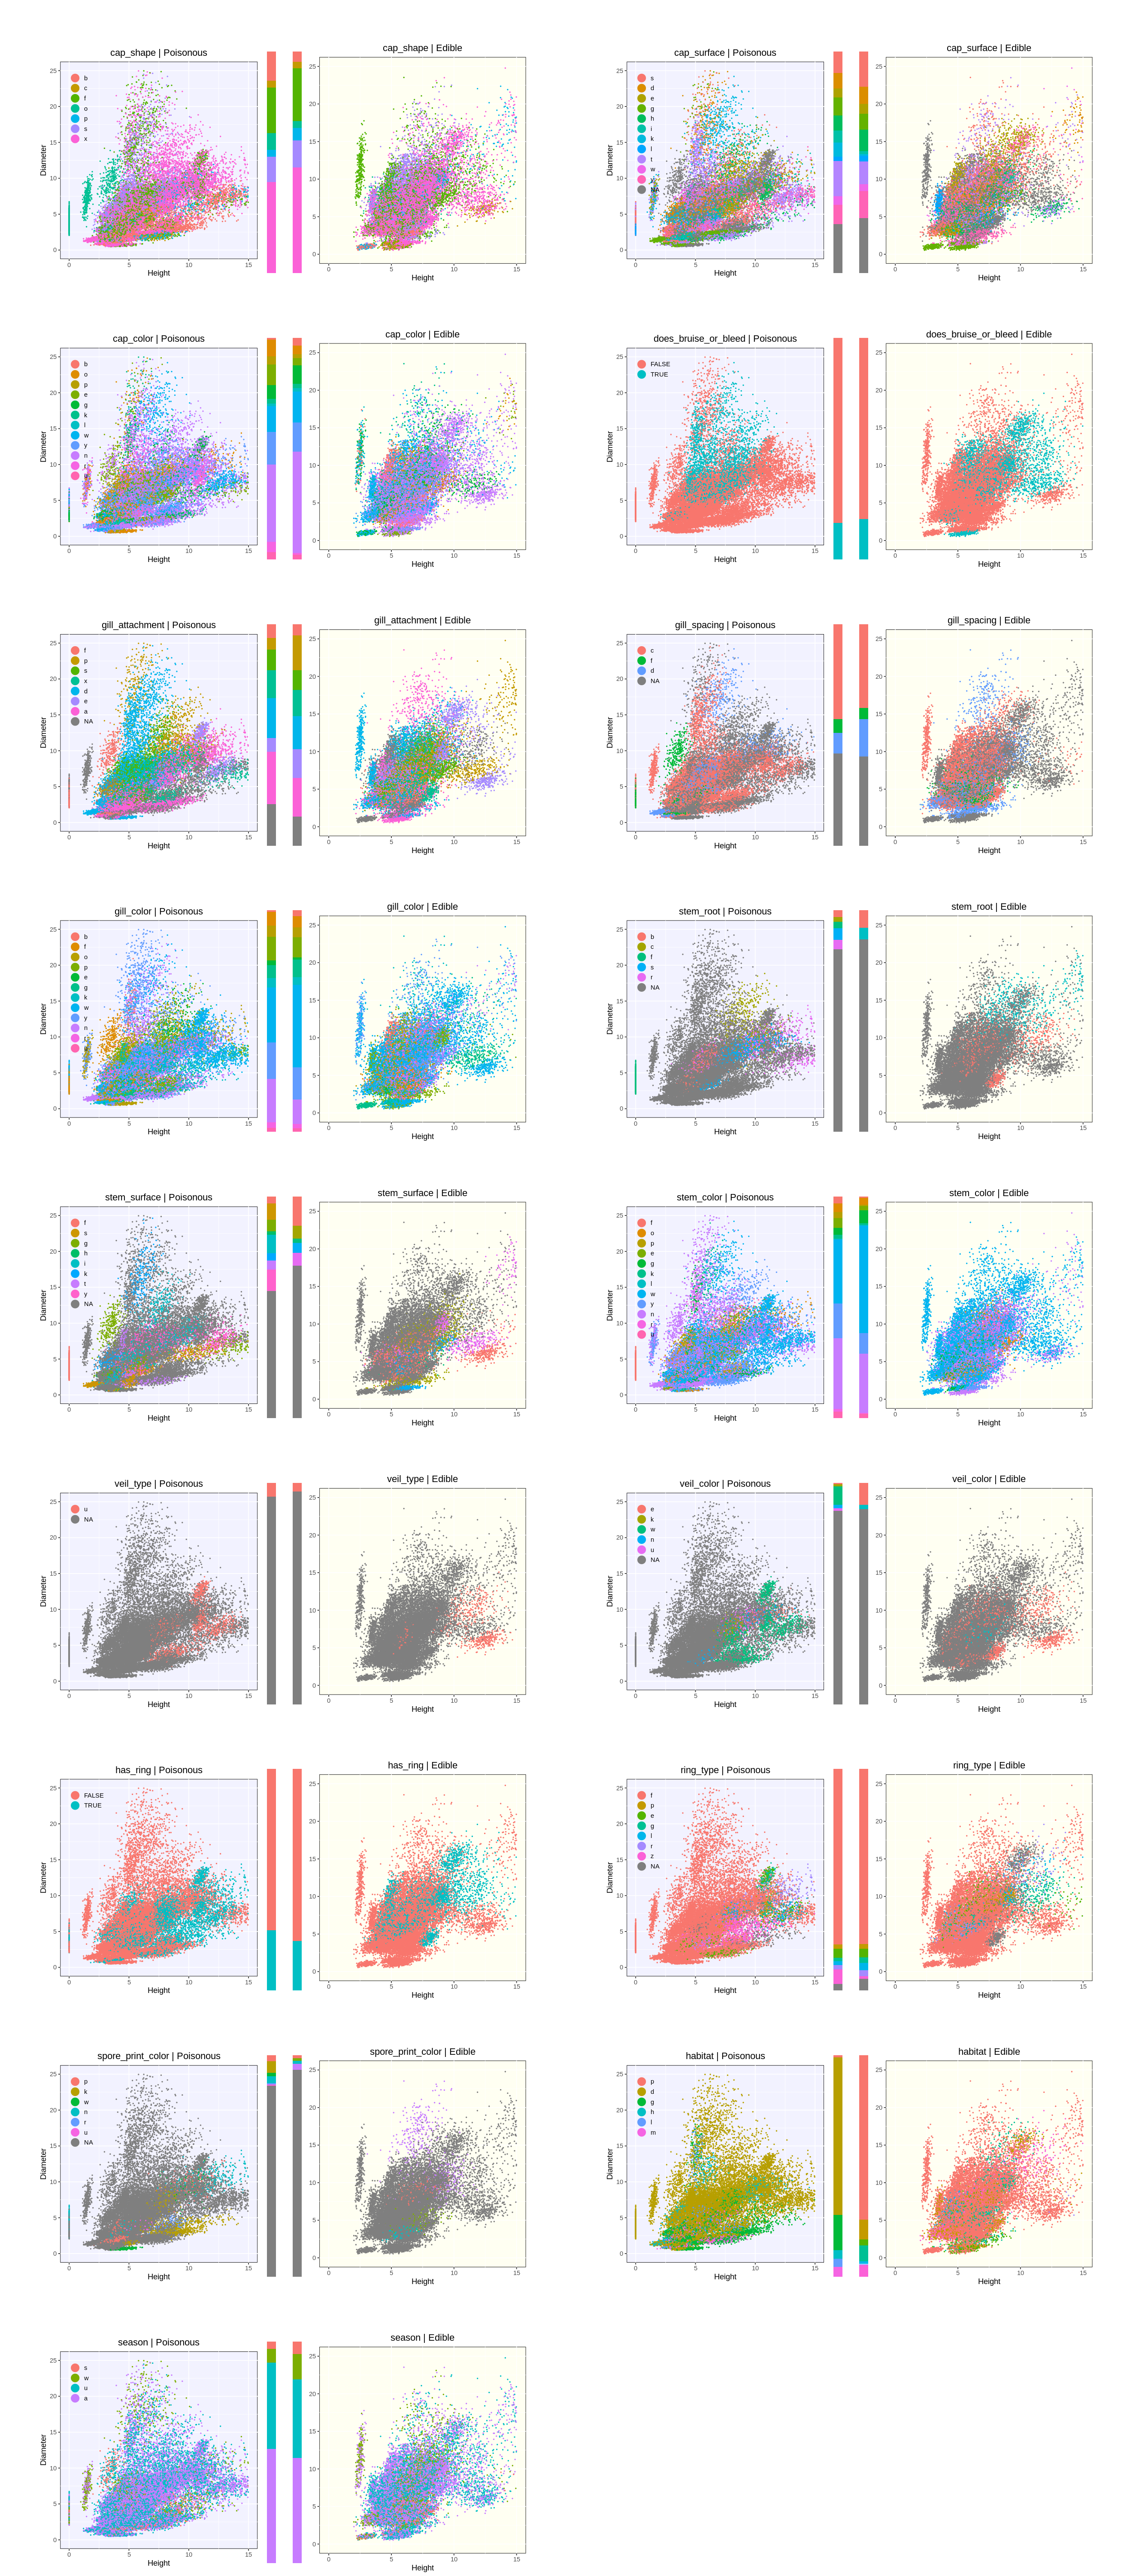

In [14]:
options(repr.plot.width = 22, repr.plot.height = 50)
plot_grid(plotlist=plots, ncol=4,byrow=TRUE, axis="tblr")

These compare the distributions and frequencies of each categorical feature between the classes. We can see that every feature is relevant to some degree, however, some some (like habitat) have massive discrepencies between the classes while others (has_ring) are only slightly different.

## Methods:

#### We have three types of features: continuous, binary, and categorical
- Continuous features
    - width, height, diameter
- Binary features
    - does_bruise_or_bleed, veil-type, has-ring
    - Can be represented as continuous features by assigning one value to 0, and the other to 1
- Categorical features
    - all other features
    - Can be broken into multiple binary features (i.e. "color" could turn into "isRed", "isBlue", and "isGreen") before further converting into continuous features

We will use a k-nearest-neighbors model to classify our examples. We will begin with only the continuous variables in our feature set. Later, we will add some binary and categorical features to the model to try to increase accuracy. To avoid optimization bias and overfitting, we will use our visualizations to select only relevant features. 

#### Visualization of the results

- Scatterplots: to visualize the prediction accuracy of each model

Pairing each two continuous variables on the axises, create three parallel plots. Dots will be colored according to the predictive results - true poisonous, true edible, false poisonous, and false edible. This will tell us where our model struggles.

- Bar graph: to compare the prediction accuracy between different models

Bar graphs of the percentages of the four categories above. We will use the bar graphs to compare the results of our models with different hyperparameters. For example, different values of K, and different features being selected.

## Expected outcomes and significance:

#### - Expectations:

We expect out model will do better than just picking the most common label. We also expect a higher accuracy after adding additional features to our model.

#### - Impact:

There is currently no common methodologies other than relying on a mushroom expert to distinguish between poisonous and edible mushrooms (citation: https://www.betterhealth.vic.gov.au/health/healthyliving/fungi-poisoning). Our model could provide the public a tool for identifying the edibility of varieties and assist experts in making judgments. 

#### - Future Questions and possible improvements:

Our model could be difficult both to collect data for and to use because of the large number of features. Future data scientists might adjust our model to take images as input to make these easier. Additionally, an improved model might use regression to predict a numerical value for a mushroom's toxicity to better represent its non-binary effects.